In [1]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import PIL
import os
import argparse
import torchvision
import matplotlib.pyplot as plt
import pandas as pd
import torchvision.transforms.functional as TF
from torchvision import transforms
import random
import cv2

import torch.optim as optim
from torch.optim import lr_scheduler
import time
from collections import defaultdict
from tqdm import tqdm
import torch.nn.functional as F


In [2]:

def compute_iou(y_true, y_pred):
    
    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum() - intersection
    x = (intersection + 1e-15) / (union + 1e-15)
    x = x.astype(np.float32)
    
    return x


## Define UNet Module

In [3]:
# code from https://colab.research.google.com/github/usuyama/pytorch-unet/blob/master/pytorch_unet_resnet18_colab.ipynb#scrollTo=b8EJl0hcC5DH

import torch.nn as nn
import torchvision.models


def convrelu(in_channels, out_channels, kernel, padding):
  return nn.Sequential(
    nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
    nn.ReLU(inplace=True),
  )


class ResNetUNet(nn.Module):
  def __init__(self, n_class):
    super().__init__()

    self.base_model = torchvision.models.resnet18(pretrained=True)
    self.base_layers = list(self.base_model.children())

    self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
    self.layer0_1x1 = convrelu(64, 64, 1, 0)
    self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
    self.layer1_1x1 = convrelu(64, 64, 1, 0)
    self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
    self.layer2_1x1 = convrelu(128, 128, 1, 0)
    self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
    self.layer3_1x1 = convrelu(256, 256, 1, 0)
    self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
    self.layer4_1x1 = convrelu(512, 512, 1, 0)

    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
    self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
    self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
    self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

    self.conv_original_size0 = convrelu(3, 64, 3, 1)
    self.conv_original_size1 = convrelu(64, 64, 3, 1)
    self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

    self.conv_last = nn.Conv2d(64, n_class, 1)

  def forward(self, input):
    x_original = self.conv_original_size0(input)
    x_original = self.conv_original_size1(x_original)

    layer0 = self.layer0(input)
    layer1 = self.layer1(layer0)
    layer2 = self.layer2(layer1)
    layer3 = self.layer3(layer2)
    layer4 = self.layer4(layer3)

    layer4 = self.layer4_1x1(layer4)
    x = self.upsample(layer4)
    layer3 = self.layer3_1x1(layer3)
    # import pdb; pdb.set_trace()
    x = torch.cat([x, layer3], dim=1)
    x = self.conv_up3(x)

    x = self.upsample(x)
    layer2 = self.layer2_1x1(layer2)
    x = torch.cat([x, layer2], dim=1)
    x = self.conv_up2(x)

    x = self.upsample(x)
    layer1 = self.layer1_1x1(layer1)
    x = torch.cat([x, layer1], dim=1)
    x = self.conv_up1(x)

    x = self.upsample(x)
    layer0 = self.layer0_1x1(layer0)
    x = torch.cat([x, layer0], dim=1)
    x = self.conv_up0(x)

    x = self.upsample(x)
    x = torch.cat([x, x_original], dim=1)
    x = self.conv_original_size2(x)

    out = self.conv_last(x)

    return out

## Define Dataset and Dataloader

In [33]:
class CBIS_DDSM(Dataset):
    # including hard labels & soft labels
    def __init__(self, data_path, train=True):
        # self.data, self.masks, self.targets =  data, masks, labels
        
        # self.transform = transform
        self.train = train
        
        self.img_path = []
        self.mask_path = []
        self.labels = []
        
        if self.train:
            # split_path = os.path.join(data_path,"train")
            df = pd.read_csv(os.path.join(data_path,"annotations_train.csv"))
            img_paths = df["image_full_png_path"].values
            mask_paths = df["image_mask_png_path"].values
            targets = df["binary pathology"].values
            
            self.img_path = [os.path.join(data_path,"train","full",x) for x in img_paths]
            self.mask_path = [os.path.join(data_path,"train","merged_masks",x) for x in mask_paths]
            self.labels = targets
            

        else:  
            #test set    
            df = pd.read_csv(os.path.join(data_path,"annotations_test.csv"))
            img_paths = df["image_full_png_path"].values
            mask_paths = df["image_mask_png_path"].values
            targets = df["binary pathology"].values
            
            self.img_path = [os.path.join(data_path,"test","full",x) for x in img_paths]
            self.mask_path = [os.path.join(data_path,"test","merged_masks",x) for x in mask_paths]
            self.labels = targets
            

    def transform_train(self, image, mask, size1=270, size=256):
        # Resize
        resize = transforms.Resize(size=(size1, size1))
        image = resize(image)
        mask = resize(mask)

        # Random crop
        i, j, h, w = transforms.RandomCrop.get_params(
            image, output_size=(size, size))
        image = TF.crop(image, i, j, h, w)
        mask = TF.crop(mask, i, j, h, w)

        # Random horizontal flipping
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # # Random vertical flipping
        if random.random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)

        # Transform to tensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        
        mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
        
        # Normalize
        image = TF.normalize(image, mean=mean, std=std)
        # mask = TF.normalize(mask, mean=mean, std=std)              #do not normalize mask
        
        return image, mask
    
    def transform_test(self, image, mask, size1=270, size=256):
        # Resize
        resize = transforms.Resize(size=(size1, size1))
        image = resize(image)
        mask = resize(mask)

#         Random crop
#         i, j, h, w = transforms.CenterCrop.get_params(
#             image, output_size=(size, size))
        image = TF.center_crop(image,size)
        mask = TF.center_crop(mask, size)

#         # Random horizontal flipping
#         if random.random() > 0.5:
#             image = TF.hflip(image)
#             mask = TF.hflip(mask)

#         # # Random vertical flipping
#         if random.random() > 0.5:
#             image = TF.vflip(image)
#             mask = TF.vflip(mask)

        # Transform to tensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        
        mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
        
        #  Normalize
        image = TF.normalize(image, mean=mean, std=std)
        # mask = TF.normalize(mask, mean=mean, std=std)
        
        return image, mask
    
    
            
            
    def __getitem__(self, index):
        img, mask, target = self.img_path[index], self.mask_path[index], self.labels[index]
            
        img = cv2.imread(img)   #The image was saved using cv2. For some reason it only works if read using cv2 and then moving to PIL
        img  = Image.fromarray(img) # transform into PIL image
        mask = cv2.imread(mask)
        mask = Image.fromarray(mask).convert('1')
        # img = Image.open(img).convert('RGB')
        # mask = Image.open(mask).convert('RGB')
        
        # if self.transform is not None:
        #     img = self.transform(img)
        #     mask = self.transform(mask)    #need to garantee that the transform is the same for image and mask
        
        if self.train:
            img, mask = self.transform_train(img, mask)
        else:
            img, mask = self.transform_test(img, mask)
            
        
            

        sample = {'image':img, 'mask': mask, 'target':target, 'index':index, 'path':self.img_path[index]}
        return sample


    def __len__(self):
        return len(self.img_path)
    


In [23]:
def get_loaders(args, **kwargs):
#     mean = [0.5071, 0.4867, 0.4408]
#     std = [0.2675, 0.2565, 0.2761]
#     size = 100
    
#     transform_train = torchvision.transforms.Compose([
#         torchvision.transforms.Resize(size, interpolation=PIL.Image.BICUBIC),
#         torchvision.transforms.RandomCrop(size, padding=4),
#         torchvision.transforms.RandomHorizontalFlip(),
#         torchvision.transforms.ToTensor(),
#         torchvision.transforms.Normalize(mean, std),
#     ])
        
#     transform_test = torchvision.transforms.Compose([
#         torchvision.transforms.Resize(size, interpolation=PIL.Image.BICUBIC),
#         torchvision.transforms.CenterCrop(size),
#         torchvision.transforms.ToTensor(),
#         torchvision.transforms.Normalize(mean, std)
#     ])
    
    trainset = CBIS_DDSM(data_path = args['data_path'], train=True)
    testset = CBIS_DDSM(data_path = args['data_path'], train=False)
    
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=args['batch_size'], shuffle=True, **kwargs) #Normal training
    test_loader = torch.utils.data.DataLoader(testset, batch_size=args['batch_size'], shuffle=False, **kwargs) #Normal test
    
    return train_loader, test_loader
    

## Load Model

In [6]:

if not torch.cuda.is_available():
  raise Exception("GPU not availalbe. CPU training will be too slow.")

print("device name", torch.cuda.get_device_name(0))

device name GeForce GTX 1080 Ti


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device', device)


device cuda


## Define the main training loop

In [8]:
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

def print_metrics(metrics, epoch_samples):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("Metrics: {}".format(", ".join(outputs)))


def test_model(model, testloader):
    
    model.eval()
    
    metrics = defaultdict(float)
    num_samples =0 
    
    with torch.no_grad():
        
        for i, batch in enumerate(tqdm(testloader)):

            inputs, mask = batch['image'], batch['mask']
            mask = mask.mean(1,keepdim=True)  #transform from [batch_size, 3, size, size] to [batch,size, 1, size, size]
            inputs = inputs.to(device)
            mask = mask.to(device)

            outputs = model(inputs)
            loss = calc_loss(outputs, mask, metrics)
            
            # statistics
            num_samples += inputs.size(0)

    print_metrics(metrics, num_samples)

    
    

In [34]:
### Parameters

num_epochs = 3

num_class = 1 #binary problem  
model = ResNetUNet(num_class).to(device)

# freeze backbone layers
for l in model.base_layers:
    for param in l.parameters():
        param.requires_grad = False
        
        
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)

args={
    'data_path': "/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed",
    "batch_size": 10
}


train_loader, test_loader = get_loaders(args)

In [35]:


## Training Loop
best_loss = 1e10

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    since = time.time()
    model.train()
    
    metrics = defaultdict(float)
    epoch_samples = 0

    print(f"Epoch {epoch} - Training...\n")
    # for inputs, labels in dataloaders[phase]:
    for i, batch in enumerate(tqdm(train_loader)):
        
        inputs, mask = batch['image'], batch['mask']
        mask = mask.mean(1,keepdim=True)  #transform from [batch_size, 3, size, size] to [batch,size, 1, size, size]
        inputs = inputs.to(device)
        mask = mask.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        # with torch.set_grad_enabled(phase == 'train'):
        outputs = model(inputs)
        
        loss = calc_loss(outputs, mask, metrics, bce_weight=1)

        loss.backward()
        optimizer.step()

        # statistics
        epoch_samples += inputs.size(0)

    scheduler.step()
    
    #test
    print("Testing...")
    test_model(model, test_loader)
    
    # print_metrics(metrics, epoch_samples, phase)
    # epoch_loss = metrics['loss'] / epoch_samples

#     if phase == 'train':
#       scheduler.step()
#       for param_group in optimizer.param_groups:
#           print("LR", param_group['lr'])


    time_elapsed = time.time() - since
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

torch.save(model.state_dict(), "trained_model.pth")



Epoch 0/2
----------
Epoch 0 - Training...



100%|██████████| 124/124 [07:27<00:00,  3.61s/it]


Testing...


100%|██████████| 37/37 [02:09<00:00,  3.49s/it]


Metrics: bce: 0.029378, dice: 0.966475, loss: 0.497927
9m 37s
Epoch 1/2
----------
Epoch 1 - Training...



100%|██████████| 124/124 [14:15<00:00,  6.90s/it]


Testing...


100%|██████████| 37/37 [14:35<00:00, 23.66s/it]


Metrics: bce: 0.023609, dice: 0.914287, loss: 0.468948
28m 51s
Epoch 2/2
----------
Epoch 2 - Training...



100%|██████████| 124/124 [39:31<00:00, 19.12s/it]


Testing...


100%|██████████| 37/37 [10:13<00:00, 16.59s/it]


Metrics: bce: 0.022040, dice: 0.862847, loss: 0.442444
49m 45s


In [36]:
# Check segmentation quality

test_iter = iter(test_loader)
batch = test_iter.next()

with torch.no_grad():
        
    inputs, mask = batch['image'], batch['mask']
    mask = mask.mean(1,keepdim=True)  #transform from [batch_size, 3, size, size] to [batch,size, 1, size, size]
    inputs = inputs.to(device)
    mask = mask.to(device)

    outputs = model(inputs)


In [37]:
def unnormalize(img, std=[0.5,0.5,0.5], mean=[0.5,0.5,0.5]):
    # Unormalize image
    MEAN = torch.tensor(mean)
    STD = torch.tensor(std)

    x = img * STD[:, None, None] + MEAN[:, None, None]
    return x

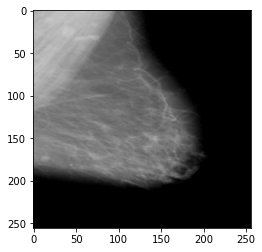

In [336]:
plt.imshow(  unnormalize(batch['image'][3]).permute(1, 2, 0)  )
# plt.imshow(  batch['image'][0] )


In [96]:
batch['mask'][0].min()

tensor(0.)

In [58]:
 unnormalize(batch['mask'][0]).shape

torch.Size([3, 256, 256])

In [61]:
batch['mask'][0].permute(1, 2, 0).squeeze(axis=2).shape

torch.Size([256, 256])

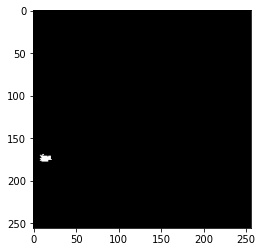

In [337]:
# plt.imshow(  255*unnormalize(batch['mask'][0]).permute(1, 2, 0)  , cmap='gray')
plt.imshow( batch['mask'][3].permute(1, 2, 0).squeeze(axis=2), cmap='gray'  )

In [64]:
torch.sigmoid(outputs.cpu()[0]).shape

torch.Size([1, 256, 256])

In [56]:
255*torch.sigmoid(outputs.cpu()[0]).max()

tensor(125.0380)

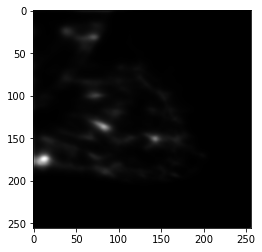

In [338]:
#plt.imshow(  unnormalize(torch.sigmoid(outputs.cpu()[0])).permute(1, 2, 0)  )
plt.imshow(  torch.sigmoid(outputs.cpu()[3]).permute(1, 2, 0).squeeze(axis=2), cmap='gray'  )
# plt.imshow(  batch['image'][0] )


In [91]:
my_mask= batch['mask'][0].permute(1, 2, 0).squeeze(axis=2)
my_mask.max()

tensor(1.)

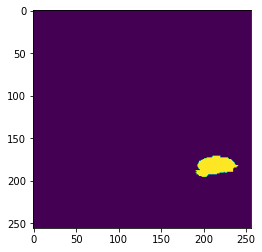

In [132]:
plt.imshow(255*cv_my_mask)

In [204]:
cv_image.shape

(256, 256, 3)

In [207]:
batch['mask'][0].permute(1, 2, 0).type(torch.uint8).numpy().shape

(256, 256, 1)

In [331]:
from torchvision.utils import save_image
save_image(unnormalize(batch['image'][0]), 'temp_img.png')

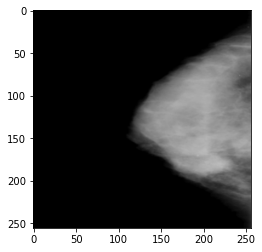

In [332]:
im = cv2.imread('temp_img.png')
plt.imshow(im)

In [333]:
import cv2
import numpy as np
# cv_image = unnormalize(batch['image'][0]).permute(1, 2, 0).numpy()
# cv_image_main = cv_image[:,:,0]
cv_image_main = im
cv_my_mask= batch['mask'][0].permute(1, 2, 0).squeeze(axis=2).type(torch.uint8).numpy()

# cv_my_mask, _ = cv2.threshold(cv_my_mask, 127, 255, 0)
# cv_my_mask= batch['mask'][0].permute(1, 2, 0).type(torch.uint8).numpy()
# cv_my_mask= batch['mask'][0].permute(1, 2, 0).squeeze(axis=2).numpy()

# Dictionary giving RGB colour for label (segment label) - label 1 in red, label 2 in yellow
# RGBforLabel = { 1:(0,255,0), 2:(0,255,255) }

# Find external contours
#_,contours,_ = cv2.findContours(cv_my_mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
contours,_ = cv2.findContours(cv_my_mask.astype(np.uint8),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
contours_pred,_ = cv2.findContours(cv_my_mask.astype(np.uint8),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)

_ = cv2.drawContours(im, contours, -1, (0,255,0), 1)


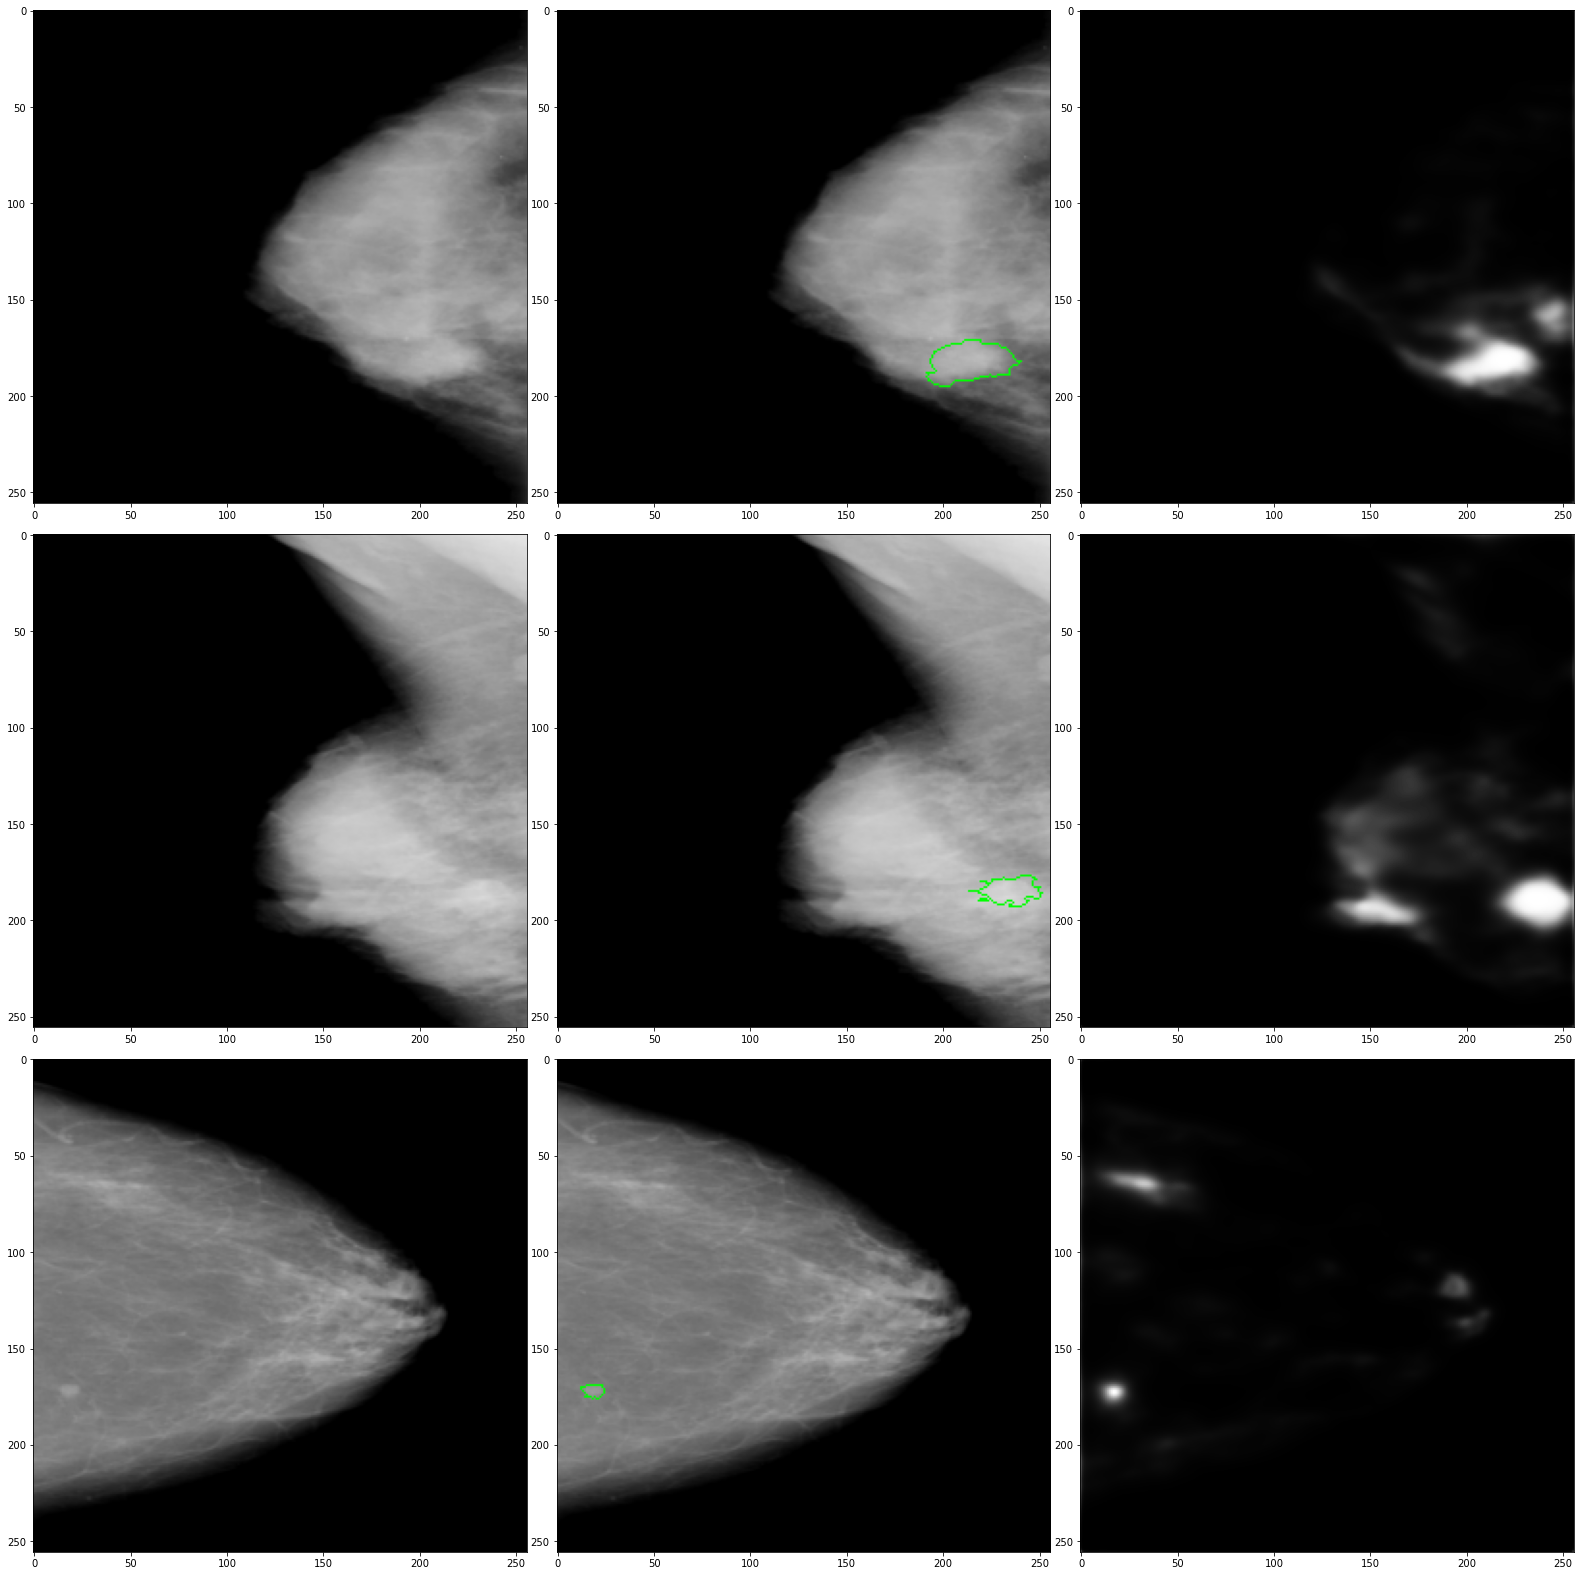

In [350]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize = (22, 22))

for i in range(3):
    
    save_image(unnormalize(batch['image'][i]), 'temp_img.png')
    im = cv2.imread('temp_img.png')
    ax[i][0].imshow(im)
    
    my_mask= batch['mask'][i].permute(1, 2, 0).squeeze(axis=2).type(torch.uint8).numpy()
    
    contours,_ = cv2.findContours(my_mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    _ = cv2.drawContours(im, contours, -1, (0,255,0), 1)
    ax[i][1].imshow(im)
    ax[i][2].imshow(torch.sigmoid(outputs.cpu()[i]).permute(1, 2, 0).squeeze(axis=2), cmap='gray' )  #pred

plt.tight_layout()

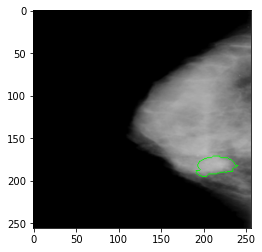

In [334]:
plt.imshow(im)